# AS-Bridge Anomaly Score Histogram


In [ ]:
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt

# --- CSV paths (edit as needed) ---
lens_csv = Path('AS-Bridge/anomaly_scores/anomaly_score_lens.csv')
nonlens_csv = Path('AS-Bridge/anomaly_scores/anomaly_score_nonlens.csv')


In [ ]:
def load_scores(path):
    ids = []
    scores = []
    with open(path, 'r', encoding='utf-8') as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            if 'anomaly_score' not in row:
                continue
            scores.append(float(row['anomaly_score_norm']))
            if 'id' in row:
                ids.append(str(row['id']))
            elif 'index' in row:
                ids.append(str(row['index']))
            else:
                ids.append('')
    return np.asarray(scores, dtype=np.float32), ids

lens_scores, lens_ids = load_scores(lens_csv)
nonlens_scores, nonlens_ids = load_scores(nonlens_csv)

print('lens scores:', float(np.mean(lens_scores)))
print('nonlens scores:',  float(np.mean(nonlens_scores)))


lens scores: 0.001732790726236999
nonlens scores: 0.0009495261474512517


In [3]:
def summary_stats(scores, name=''):
    stats = {
        'mean': float(np.mean(scores)),
        'std': float(np.std(scores)),
        'min': float(np.min(scores)),
        'p5': float(np.percentile(scores, 5)),
        'p25': float(np.percentile(scores, 25)),
        'median': float(np.percentile(scores, 50)),
        'p75': float(np.percentile(scores, 75)),
        'p95': float(np.percentile(scores, 95)),
        'max': float(np.max(scores)),
    }
    print(f"{name} stats:")
    for k, v in stats.items():
        print(f"  {k}: {v:.6g}")
    return stats


def rankdata(a):
    # Simple average-rank implementation (1-based)
    order = np.argsort(a)
    ranks = np.empty_like(order, dtype=np.float64)
    sorted_a = a[order]
    n = len(a)
    i = 0
    while i < n:
        j = i
        while j + 1 < n and sorted_a[j + 1] == sorted_a[i]:
            j += 1
        rank = 0.5 * (i + j) + 1.0
        ranks[order[i:j + 1]] = rank
        i = j + 1
    return ranks


def auc_score(pos_scores, neg_scores):
    scores = np.concatenate([pos_scores, neg_scores])
    labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    ranks = rankdata(scores)
    sum_pos = ranks[labels == 1].sum()
    n_pos = len(pos_scores)
    n_neg = len(neg_scores)
    if n_pos == 0 or n_neg == 0:
        return float('nan')
    auc = (sum_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)


def precision_at_k(pos_scores, neg_scores, k):
    scores = np.concatenate([pos_scores, neg_scores])
    labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    order = np.argsort(scores)[::-1]
    k = int(min(k, len(order)))
    if k <= 0:
        return float('nan')
    topk = labels[order[:k]]
    return float(topk.mean())


def fpr_at_tpr(pos_scores, neg_scores, tpr):
    tpr = float(tpr)
    if not (0.0 < tpr <= 1.0):
        return float('nan')
    # threshold so that TPR ~= tpr (scores >= thresh are positive)
    q = 100.0 * (1.0 - tpr)
    try:
        thresh = np.percentile(pos_scores, q, method='higher')
    except TypeError:
        thresh = np.percentile(pos_scores, q, interpolation='higher')
    fpr = float(np.mean(neg_scores >= thresh))
    return fpr, float(thresh)


def average_precision(pos_scores, neg_scores):
    scores = np.concatenate([pos_scores, neg_scores])
    labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    order = np.argsort(scores)[::-1]
    labels = labels[order]
    tp = 0
    precisions = []
    for i, lab in enumerate(labels, start=1):
        if lab == 1:
            tp += 1
            precisions.append(tp / i)
    if tp == 0:
        return float('nan')
    return float(np.mean(precisions))


lens_stats = summary_stats(lens_scores, 'lens')
nonlens_stats = summary_stats(nonlens_scores, 'nonlens')

auc = auc_score(lens_scores, nonlens_scores)
print(f"AUROC (lens=positive, higher score = more anomalous): {auc:.6f}")

aupr = average_precision(lens_scores, nonlens_scores)
print(f"AUPR (lens=positive): {aupr:.6f}")

for k in [500, 5000]:
    p_at_k = precision_at_k(lens_scores, nonlens_scores, k)
    print(f"P@{k}: {p_at_k:.6f}")

for tpr in [0.01, 0.05]:
    fpr, thresh = fpr_at_tpr(lens_scores, nonlens_scores, tpr)
    print(f"FPR@TPR={tpr:.2%}: {fpr:.6f} (threshold={thresh:.6g})")




lens stats:
  mean: 0.00173279
  std: 0.00124956
  min: 9.42854e-05
  p5: 0.000616752
  p25: 0.00114966
  median: 0.00158015
  p75: 0.00203574
  p95: 0.00306371
  max: 0.0285685
nonlens stats:
  mean: 0.000949526
  std: 0.000500323
  min: 5.03377e-05
  p5: 0.000323907
  p25: 0.000590362
  median: 0.000852945
  p75: 0.00121403
  p95: 0.00190485
  max: 0.00503676
AUROC (lens=positive, higher score = more anomalous): 0.800946
AUPR (lens=positive): 0.795915
P@500: 0.928000
P@5000: 0.732200
FPR@TPR=1.00%: 0.000000 (threshold=0.005816)
FPR@TPR=5.00%: 0.001800 (threshold=0.0030692)


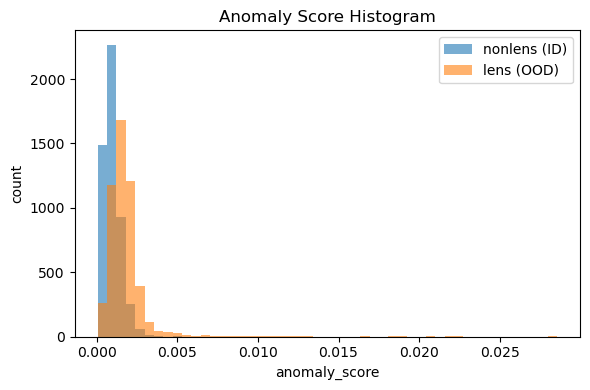

In [4]:
# Joint histogram
all_scores = np.concatenate([lens_scores, nonlens_scores])
bins = np.linspace(all_scores.min(), all_scores.max(), 50)

plt.figure(figsize=(6, 4))
plt.hist(nonlens_scores, bins=bins, alpha=0.6, label='nonlens (ID)')
plt.hist(lens_scores, bins=bins, alpha=0.6, label='lens (OOD)')
plt.title('Anomaly Score Histogram')
plt.xlabel('anomaly_score')
plt.ylabel('count')
plt.legend()
plt.tight_layout()
plt.show()
